In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
import plotly.express as px
import pycountry

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 100
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use("dark_background")

In [2]:
data = pd.read_csv("master.csv")
data.head(3)

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)    generation  
0                 796  Generation X  
1                 796        Silent  
2                 796  Generation X

## Data Preprocessing

#### Clean the column names

In [3]:
data.columns = data.columns.str.strip()

#### Change some country names to ISO-standard country names

In [4]:
data["country"] = data["country"].str.replace("Republic of Korea", "South Korea")
data["country"] = data["country"].str.replace('Saint Vincent and Grenadines', 'Saint Vincent and the Grenadines')

#### Get the corresponding continent for each country

In [5]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

data["Continent"] = data["country"].apply(country_to_continent)
data.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year gdp_for_year ($)  \
0               6.71  Albania1987           NaN    2,156,624,900   
1               5.19  Albania1987           NaN    2,156,624,900   
2               4.83  Albania1987           NaN    2,156,624,900   
3               4.59  Albania1987           NaN    2,156,624,900   
4               3.28  Albania1987           NaN    2,156,624,900   

   gdp_per_capita ($)       generation Continent  
0                 796     Generation X    Europe  
1                 796           Silent    Europe  
2                 796     Generation X    Europe  
3                 796  G.I. Generation    Europe  
4                 796          Boomers    Europe

### Get the country codes of each country

In [6]:
def country_code(country_name):
    country_alpha3 = pc.country_name_to_country_alpha3(country_name)
    return country_alpha3
data["Country Code"] = data.country.apply(country_code)

#### There's only a small amount of data in 2016 compared to other years so let's remove it

In [7]:
# Check the number of values in each year
data.year.value_counts(ascending = True)

2016     160
1986     576
1985     576
1988     588
1989     624
1987     648
2015     744
1991     768
1990     768
1992     780
1993     780
1994     816
1996     924
1997     924
1995     936
2014     936
1998     948
2013     960
2012     972
1999     996
2004    1008
2005    1008
2008    1020
2006    1020
2011    1032
2003    1032
2002    1032
2000    1032
2007    1032
2010    1056
2001    1056
2009    1068
Name: year, dtype: int64

In [8]:
# Only include samples that are not in year 2016
data = data.loc[data.year != 2016]
# Sort the values by country in alphabetical order
data = data.sort_values("country").reset_index(drop = True)

data.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  2002    male   5-14 years            1      319473   
2  Albania  2003  female    75+ years            6       49088   
3  Albania  2003    male  55-74 years           16      201520   
4  Albania  2003    male  35-54 years           28      386196   

   suicides/100k pop country-year  HDI for year gdp_for_year ($)  \
0               6.71  Albania1987           NaN    2,156,624,900   
1               0.31  Albania2002           NaN    4,435,078,648   
2              12.22  Albania2003           NaN    5,746,945,913   
3               7.94  Albania2003           NaN    5,746,945,913   
4               7.25  Albania2003           NaN    5,746,945,913   

   gdp_per_capita ($)    generation Continent Country Code  
0                 796  Generation X    Europe          ALB  
1                1573    Millenials    Europe          ALB  
2                2021        Silent    Europe          ALB  
3                2021        Silent    Europe          ALB  
4                2021       Boomers    Europe          ALB

#### There are also countries with zero data
- As can be seen below, Saint Kitts and Nevis, and Dominica has zero value

In [9]:
# Check those countries with zero data
data.groupby("country")["suicides_no"].sum().reset_index().sort_values("suicides_no").head()

country  suicides_no
74  Saint Kitts and Nevis            0
27               Dominica            0
77             San Marino            4
1     Antigua and Barbuda           11
55               Maldives           20

In [10]:
# Filter out the countries with zero value
data = data.loc[(data["country"] != "Saint Kitts and Nevis") | (data["country"] != "Dominica")]

#### There are also countries with 3 or less years worth of data so we remove it from our data

In [11]:
count = data.groupby("country")["year"].nunique().to_frame("count").sort_values("count").reset_index()
countries = count.loc[count["count"] <= 3].country.tolist()

for country in countries:
    data = data.loc[data["country"] != country]

display(countries)

['Cabo Verde',
 'Dominica',
 'Macau',
 'Bosnia and Herzegovina',
 'Saint Kitts and Nevis',
 'San Marino',
 'Oman']

#### Check for null and duplicate values

#### Locate the null values

In [13]:
data.loc[data.isna().any(axis=1)]

country  year     sex          age  suicides_no  population  \
0         Albania  1987    male  15-24 years           21      312900   
1         Albania  2002    male   5-14 years            1      319473   
2         Albania  2003  female    75+ years            6       49088   
3         Albania  2003    male  55-74 years           16      201520   
4         Albania  2003    male  35-54 years           28      386196   
...           ...   ...     ...          ...          ...         ...   
27654  Uzbekistan  1997  female  55-74 years           44      961600   
27655  Uzbekistan  1997  female  35-54 years           74     2011500   
27656  Uzbekistan  1997    male   5-14 years           37     3159000   
27657  Uzbekistan  1997  female   5-14 years            9     3071700   
27658  Uzbekistan  1996  female  35-54 years           74     1906900   

       suicides/100k pop    country-year  HDI for year gdp_for_year ($)  \
0                   6.71     Albania1987           NaN    2,156,624,900   
1                   0.31     Albania2002           NaN    4,435,078,648   
2                  12.22     Albania2003           NaN    5,746,945,913   
3                   7.94     Albania2003           NaN    5,746,945,913   
4                   7.25     Albania2003           NaN    5,746,945,913   
...                  ...             ...           ...              ...   
27654               4.58  Uzbekistan1997           NaN   14,744,603,774   
27655               3.68  Uzbekistan1997           NaN   14,744,603,774   
27656               1.17  Uzbekistan1997           NaN   14,744,603,774   
27657               0.29  Uzbekistan1997           NaN   14,744,603,774   
27658               3.88  Uzbekistan1996           NaN   13,948,892,216   

       gdp_per_capita ($)    generation Continent Country Code  
0                     796  Generation X    Europe          ALB  
1                    1573    Millenials    Europe          ALB  
2                    2021        Silent    Europe          ALB  
3                    2021        Silent    Europe          ALB  
4                    2021       Boomers    Europe          ALB  
...                   ...           ...       ...          ...  
27654                 724        Silent      Asia          UZB  
27655                 724       Boomers      Asia          UZB  
27656                 724    Millenials      Asia          UZB  
27657                 724    Millenials      Asia          UZB  
27658                 703       Boomers      Asia          UZB  

[19176 rows x 14 columns]

#### More than 2/3 of data in the HDI for year column are null so we drop it

In [14]:
data = data.drop("HDI for year", axis=1)

#### Convert gdp to integer

In [15]:
data["gdp_for_year ($)"] = data["gdp_for_year ($)"].str.replace(",", "")
data["gdp_for_year ($)"] = data["gdp_for_year ($)"].astype("int64")

## Exploratory Data Analysis

### Univariate Analysis - checking the class distributions

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27492 entries, 0 to 27659
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27492 non-null  object 
 1   year                27492 non-null  int64  
 2   sex                 27492 non-null  object 
 3   age                 27492 non-null  object 
 4   suicides_no         27492 non-null  int64  
 5   population          27492 non-null  int64  
 6   suicides/100k pop   27492 non-null  float64
 7   country-year        27492 non-null  object 
 8   gdp_for_year ($)    27492 non-null  int64  
 9   gdp_per_capita ($)  27492 non-null  int64  
 10  generation          27492 non-null  object 
 11  Continent           27492 non-null  object 
 12  Country Code        27492 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 2.9+ MB


In [17]:
def count_plot(data=data, x=None, y=None, palette = None):
    if x:
        order = data[x].value_counts().sort_values(ascending=False).index
        sns.countplot(data=data, x=x, palette = palette, order = order)
        plt.title(f"{x.capitalize()} Class Distributions")
        plt.show()
    if y:
        order = data[y].value_counts().sort_values(ascending=False).index
        sns.countplot(data=data, y=y, order=order, palette = palette)
        plt.title(f"{y.capitalize()} Class Distributions")
        plt.show()

#### Class distributions for column 'country'

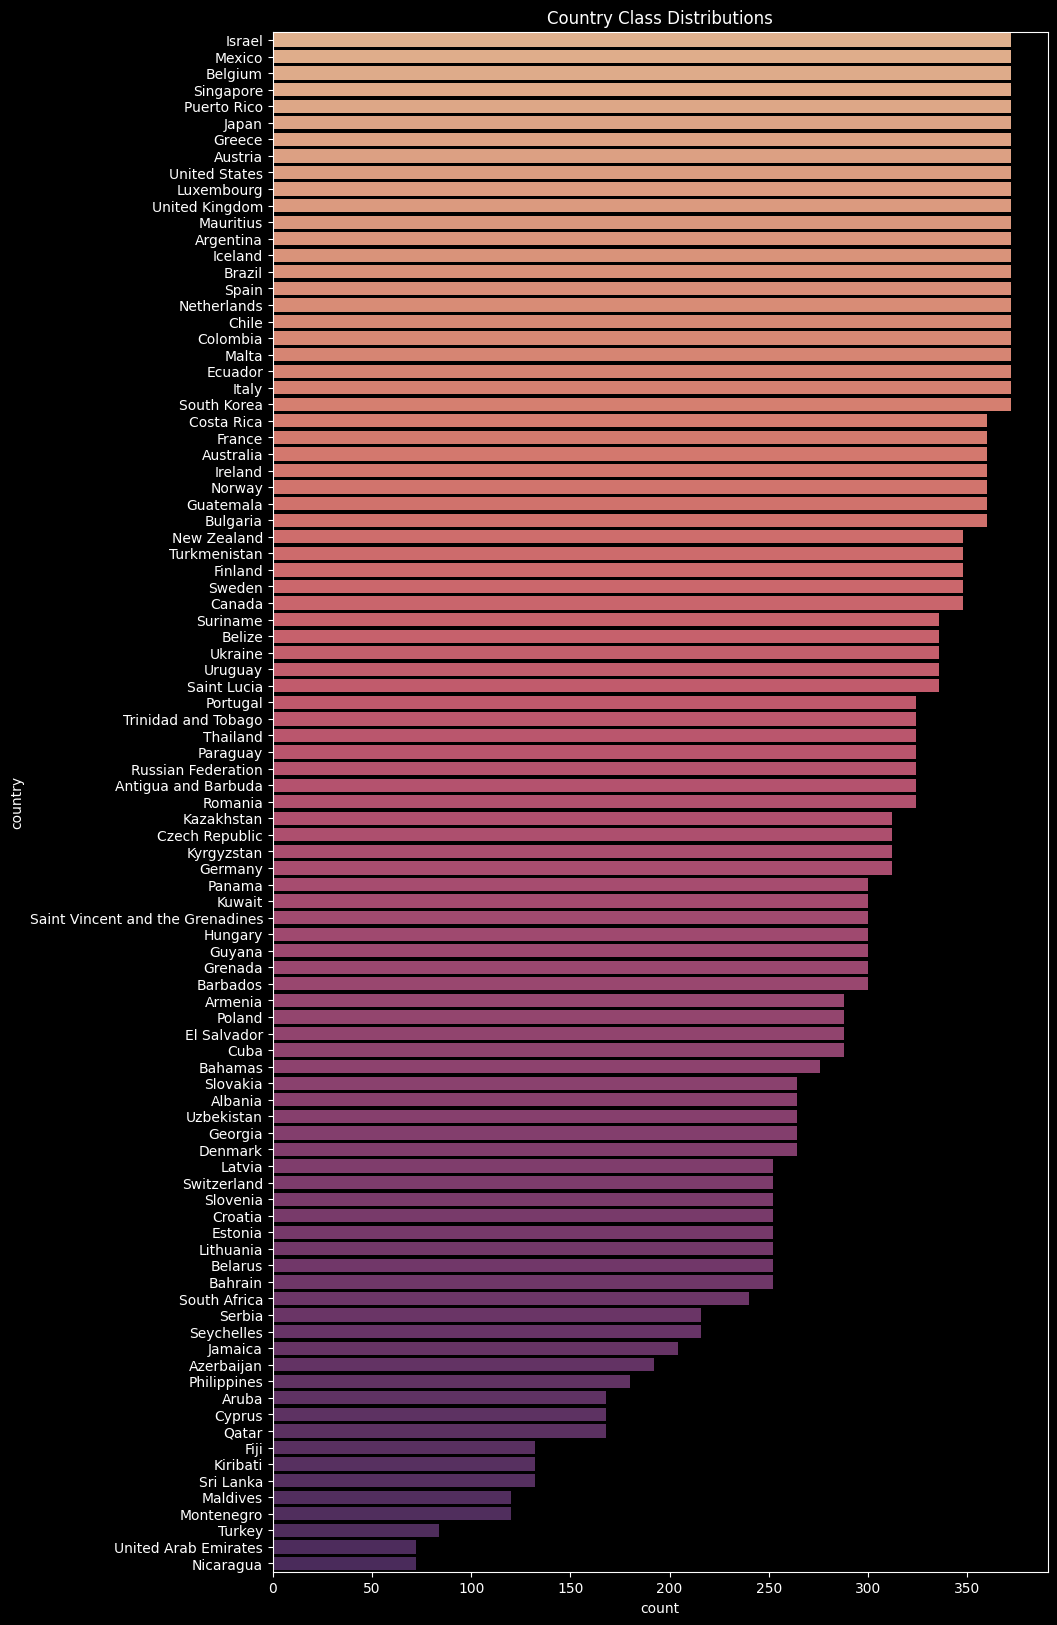

In [18]:
plt.figure(figsize = (10, 20))
count_plot(y = "country", palette = "flare")

#### Class distributions for column 'sex'
- There are equal distributions for male and female in the data

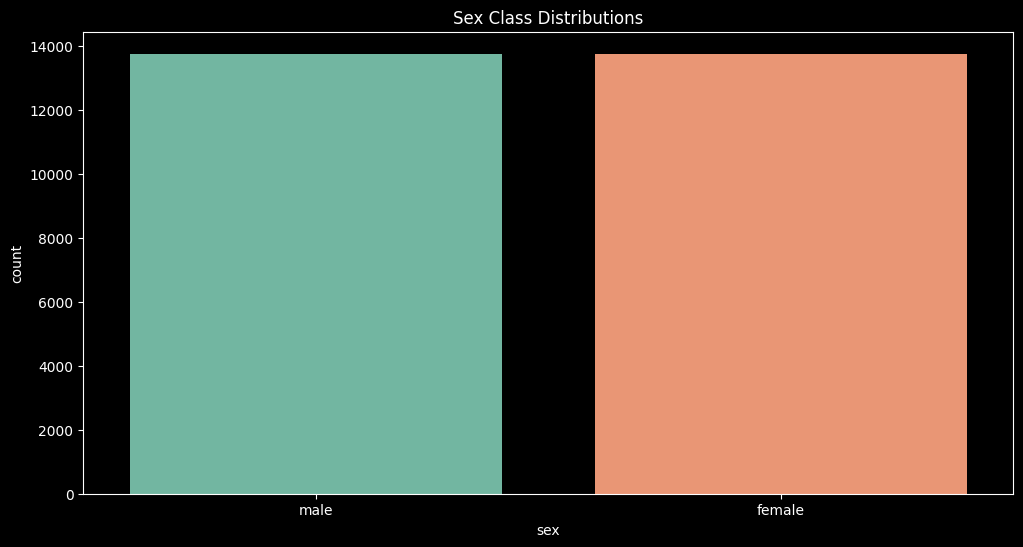

In [19]:
count_plot(x = "sex", palette = "Set2")

#### Class distributions for column 'age'
- There are also equal distributions for age

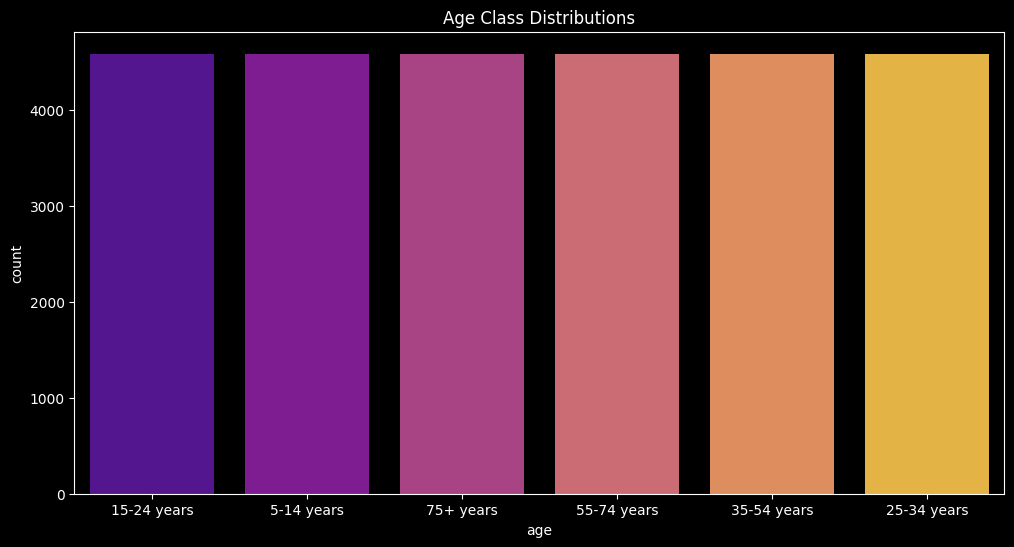

In [20]:
count_plot(x = "age", palette = "plasma")

#### Class distributions for column 'generation'
- Generation X has the highest frequency in our data while Generation Z has the lowest

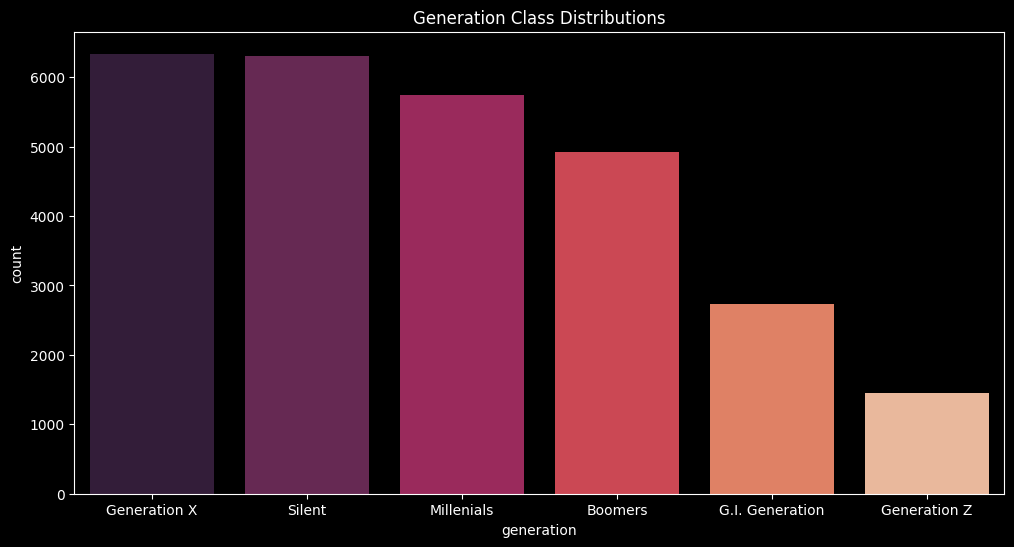

In [21]:
count_plot(x = "generation", palette = "rocket")

#### Class Distribution for column 'Continent'
- Europe has the highest frequency while Africa has the lowest

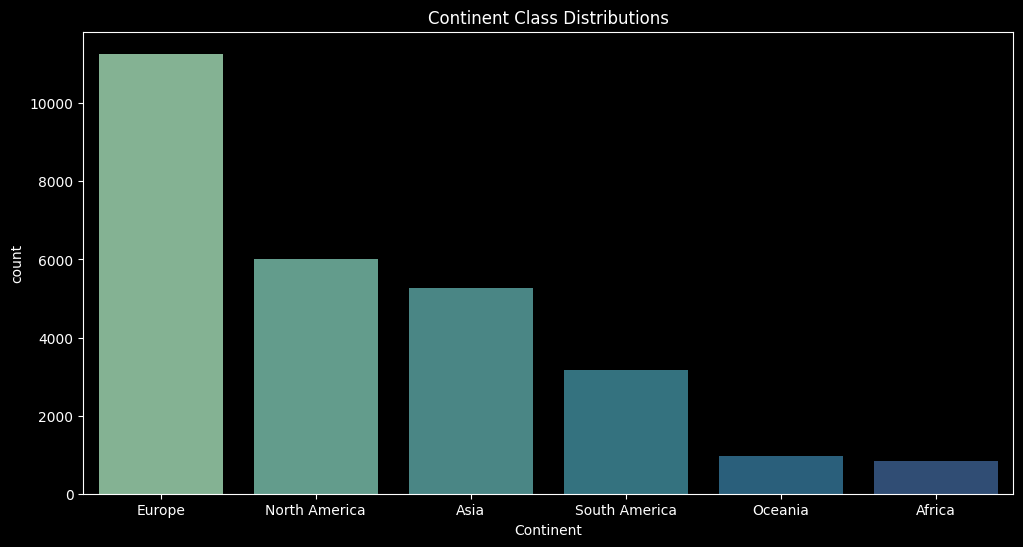

In [22]:
count_plot(x = "Continent", palette = "crest")

#### Distributions for GDP per year and GDP per capita

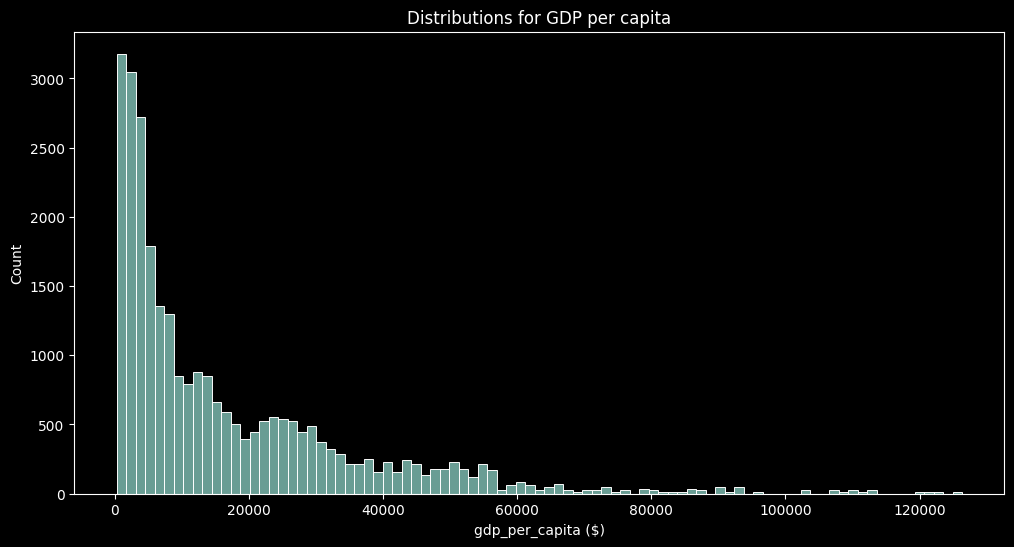

In [23]:
sns.histplot(data = data, x = "gdp_per_capita ($)")
plt.title("Distributions for GDP per capita")
plt.show()

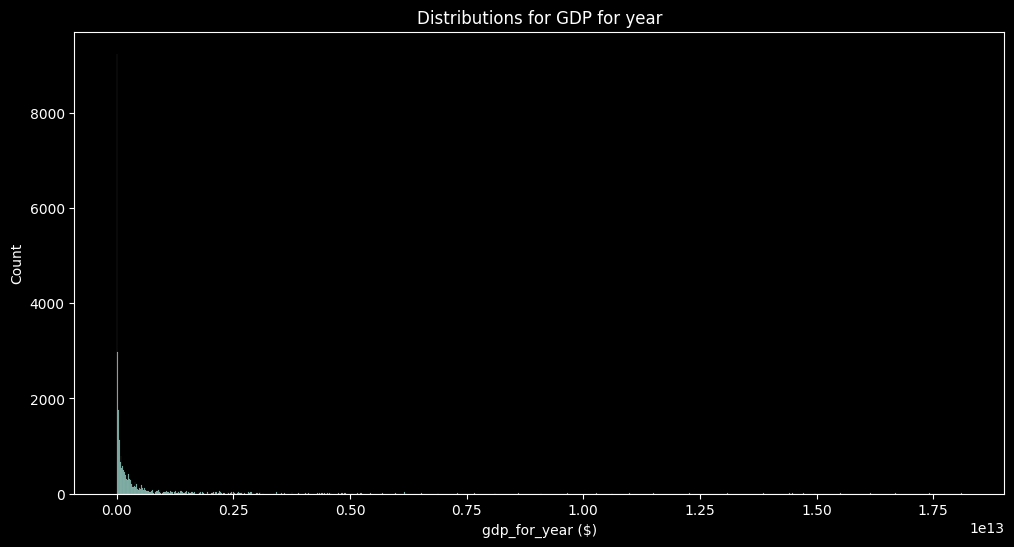

In [24]:
sns.histplot(data = data, x = "gdp_for_year ($)")
plt.title("Distributions for GDP for year")
plt.show()

### Bivariate and Multivariate Analysis

#### Distribution of the Number of Countries throughout the Year

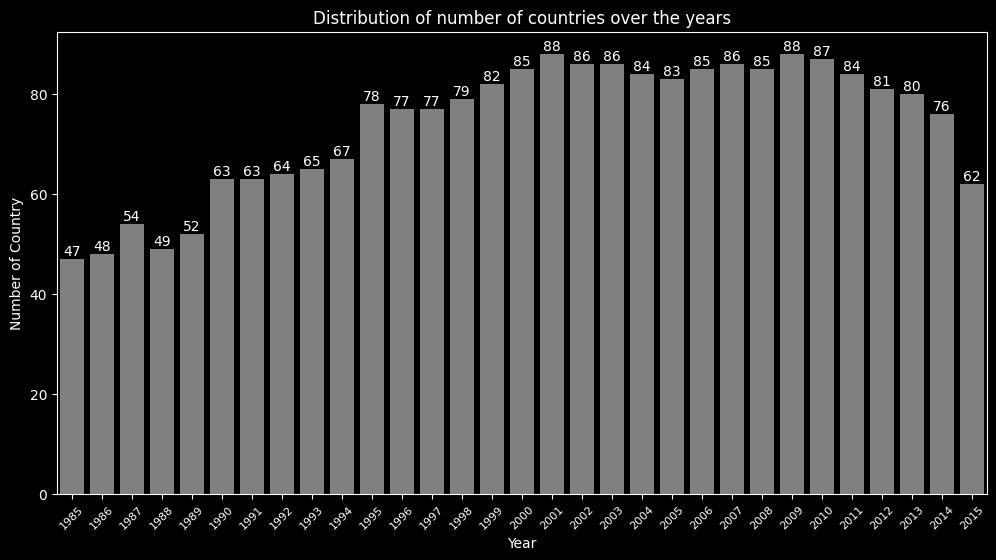

In [25]:
grouped = data.groupby("year")["country"].nunique().reset_index()

ax = sns.barplot(data = grouped, x = "year", y = "country", color = "gray")
plt.title("Distribution of number of countries over the years")
plt.ylabel("Number of Country")
plt.xlabel("Year")
plt.xticks(rotation = 45, fontsize =8)
plt.bar_label(ax.containers[0])
plt.show()

#### Suicide rate per 100k population by country
- It can be observed that most of the countries at the top are European

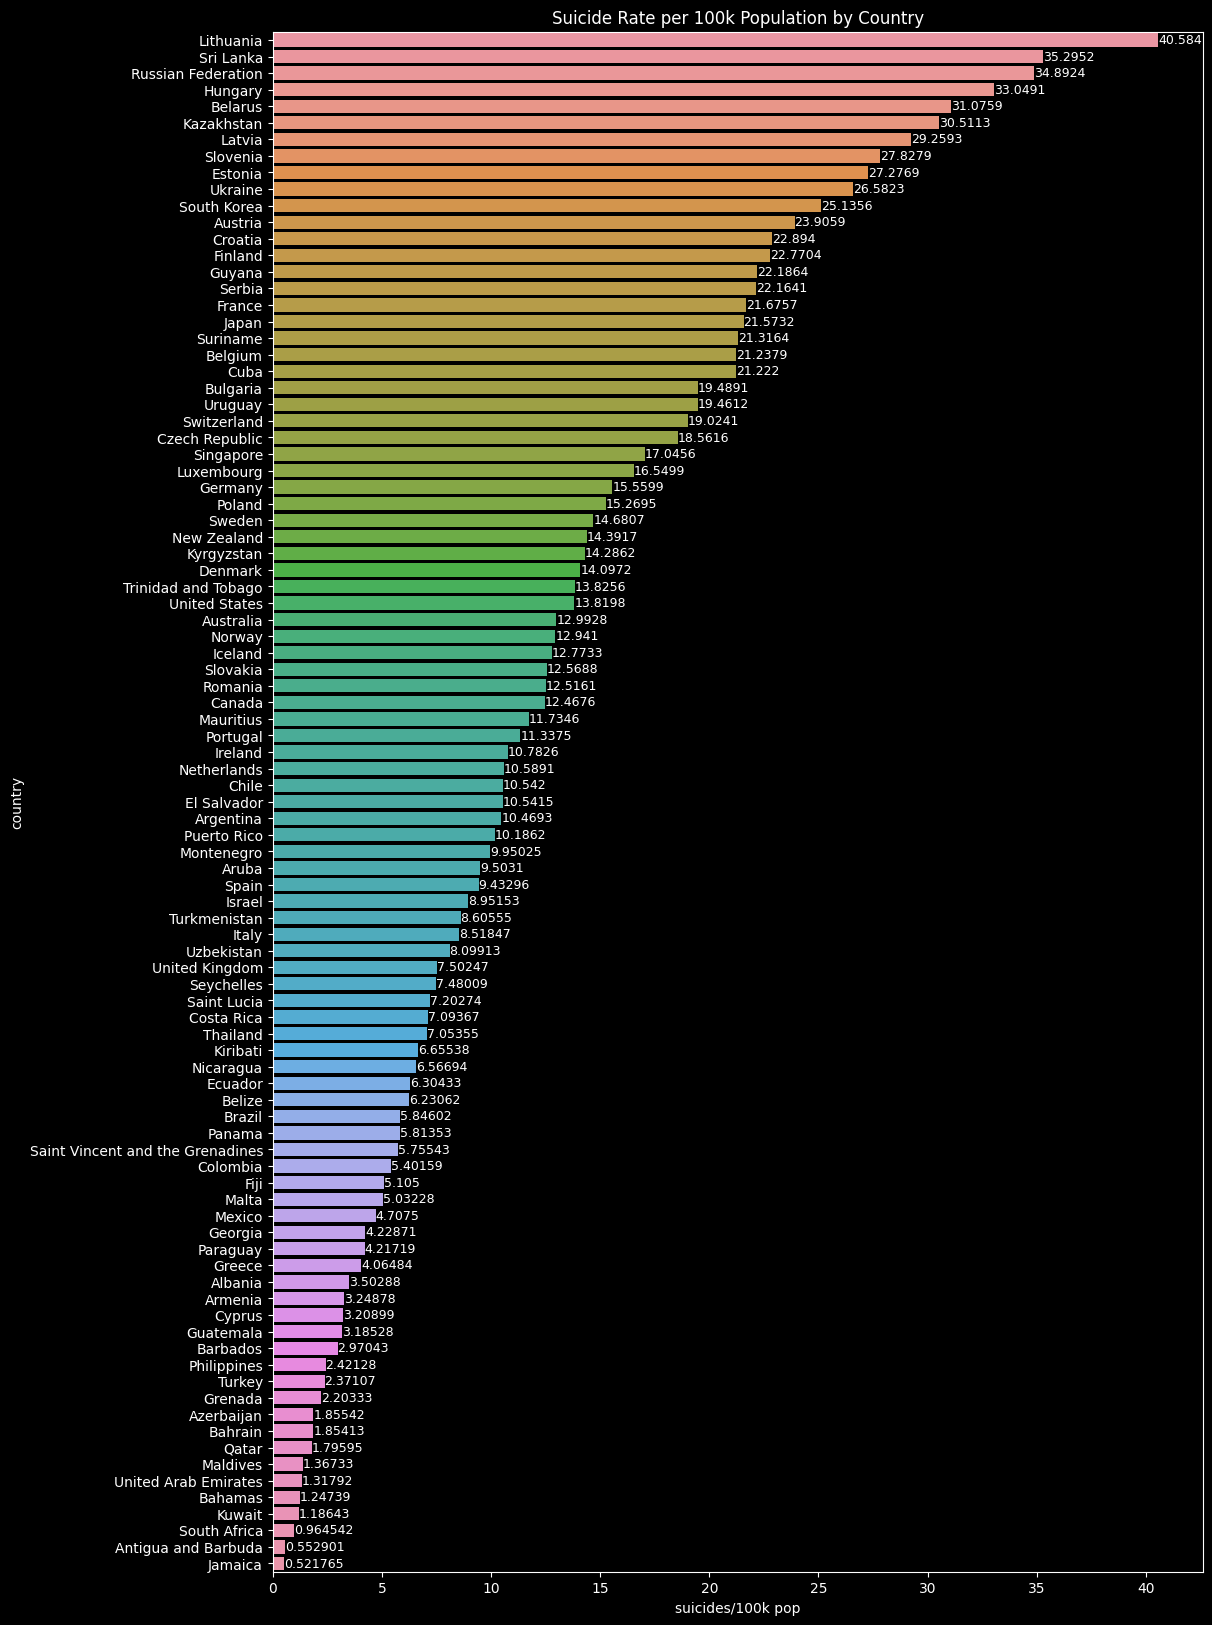

In [26]:
grouped = data.groupby("country")["suicides/100k pop"].mean().sort_values(ascending = False).reset_index()

plt.figure(figsize = (12, 20))
ax = sns.barplot(data = grouped, x = "suicides/100k pop", y = "country")
ax.bar_label(ax.containers[0], size = 9)
plt.title("Suicide Rate per 100k Population by Country")
plt.show()

#### Total number of suicides per country
- Most of the countries at the top of the list are developed countries, meaning they have a high gdp per capita

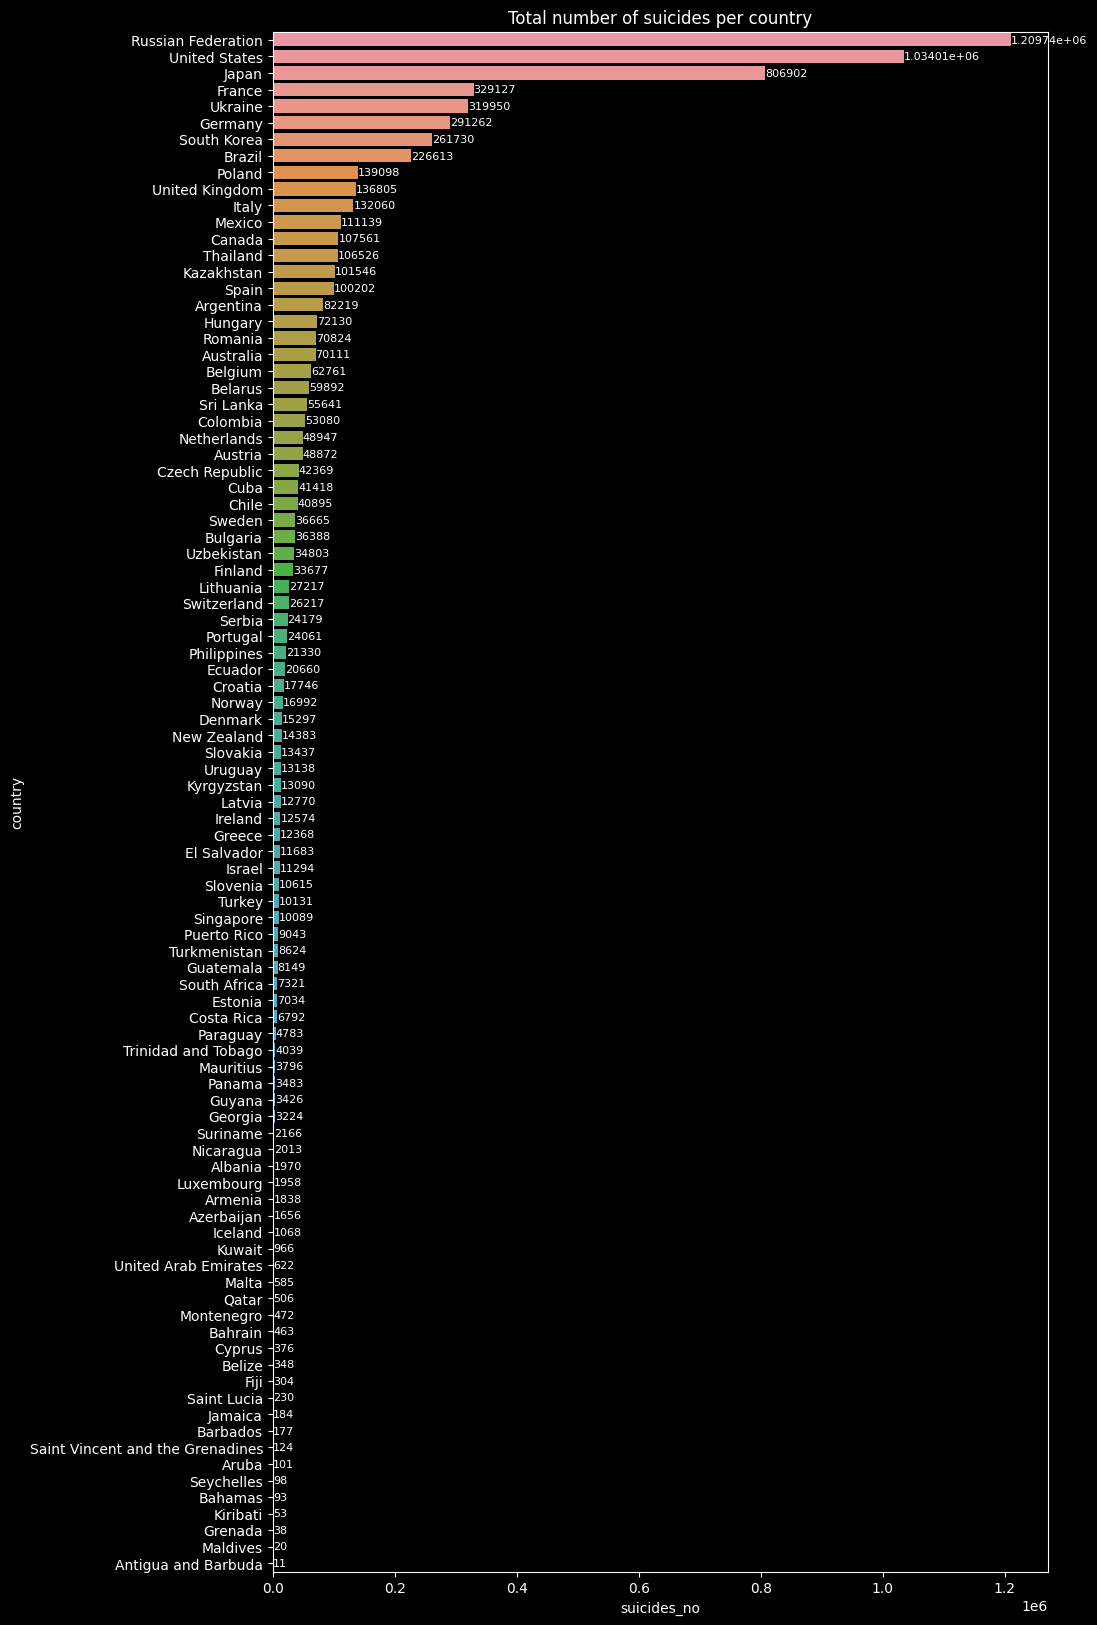

In [27]:
plt.figure(figsize = (10, 20))
grouped = data.groupby("country")["suicides_no"].sum().sort_values(ascending = False).reset_index()

ax = sns.barplot(data = grouped, x = "suicides_no", y = "country")
ax.bar_label(ax.containers[0], size = 8)
plt.title("Total number of suicides per country")

plt.show()

#### Correlation between the suicide rate and the gdp of a country
- There's a positive correlation between the two variables
- Countries with a higher GDP and GDP per capita tend to experience higher suicide rates

Upper bound is: 57048.0


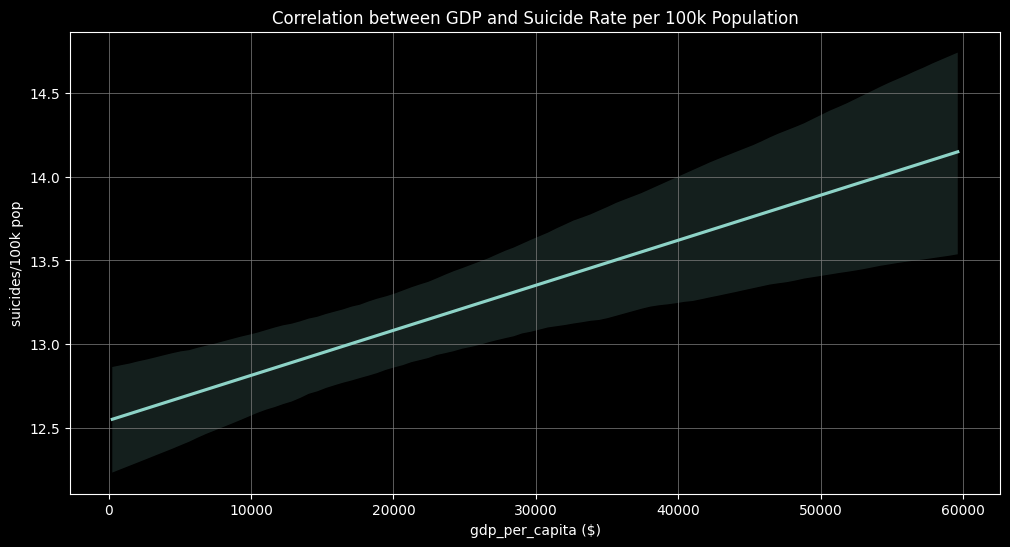

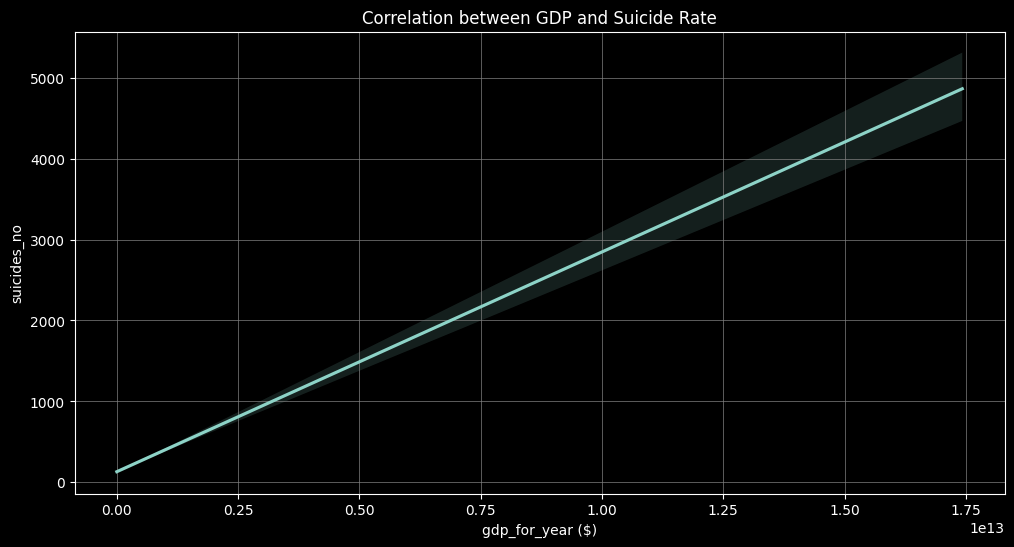

In [28]:
# It is always a good practice to remove outliers when working with numbers
# I used the IQR method to removed the outliers in the GDP per capita column
Q1 = 3418
Q3 = 24870
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR
print(f"Upper bound is: {upper_bound}")

data_no_outliers = data.loc[data["gdp_per_capita ($)"] <= 60000]

sns.regplot(data = data_no_outliers, x = "gdp_per_capita ($)", y = "suicides/100k pop", scatter = False)
plt.title("Correlation between GDP and Suicide Rate per 100k Population")
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

sns.regplot(data = data_no_outliers, x = "gdp_for_year ($)", y = "suicides_no", scatter = False)
plt.title("Correlation between GDP and Suicide Rate")
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

#### Suicide Rate per 100k Population Throughout the Years
- 1995 record the highest suicide rate per 100k population in our data
- It was observed that the suicide rate decreased over the last decade with the latest year (in our data) recording the min value

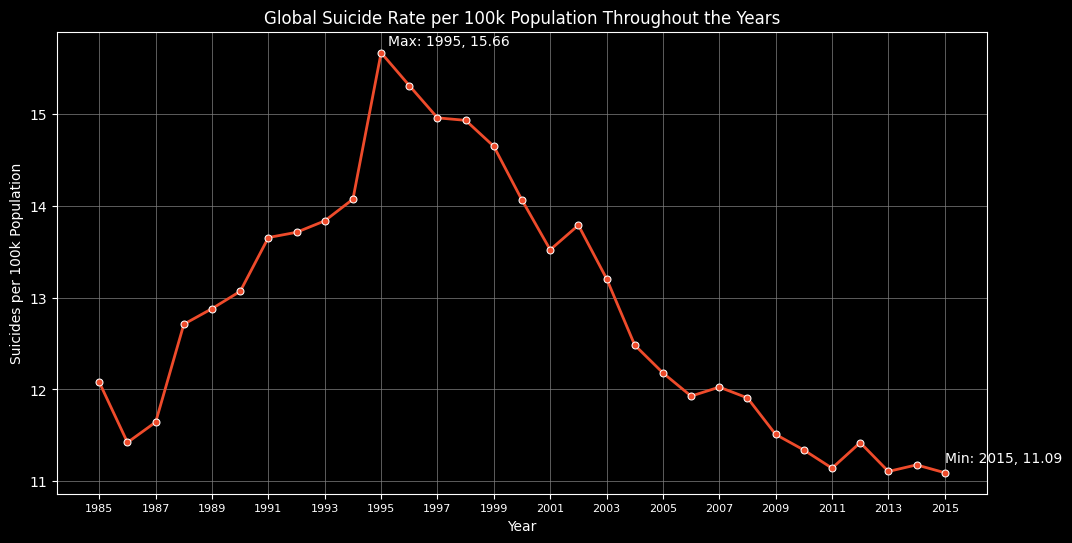

In [29]:
grouped = data.groupby("year")["suicides/100k pop"].mean().reset_index()

sns.lineplot(data = grouped, x = "year", y = "suicides/100k pop", marker = "o", color = "#EE4B2B", linewidth = 2, markersize = 5)

# Add annotations for max and min values
max_year = grouped.loc[grouped["suicides/100k pop"].idxmax(), "year"]
min_year = grouped.loc[grouped["suicides/100k pop"].idxmin(), "year"]
max_value = round(grouped["suicides/100k pop"].max(), 2)
min_value = round(grouped["suicides/100k pop"].min(), 2)

plt.annotate(f"Max: {max_year}, {max_value}", xy=(max_year, grouped["suicides/100k pop"].max()), xytext=(5, 3),
             textcoords="offset points", color="white", ha='left', va='bottom')
plt.annotate(f"Min: {min_year}, {min_value}", xy=(min_year, grouped["suicides/100k pop"].min()), xytext=(0, 15),
             textcoords="offset points", color="white", ha='left', va='top')

plt.title("Global Suicide Rate per 100k Population Throughout the Years")
plt.xlabel("Year")
plt.ylabel("Suicides per 100k Population")
plt.xticks(range(1985, 2016, 2), fontsize = 8)
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

#### Suicide Rates per 100k Population by Year and Sex
- There has been a subsequent decrease in suicide rates per 100k population over the years for both sex
- The male population experiences significantly elevated suicide rates and a considerably greater total number of suicides compared to females

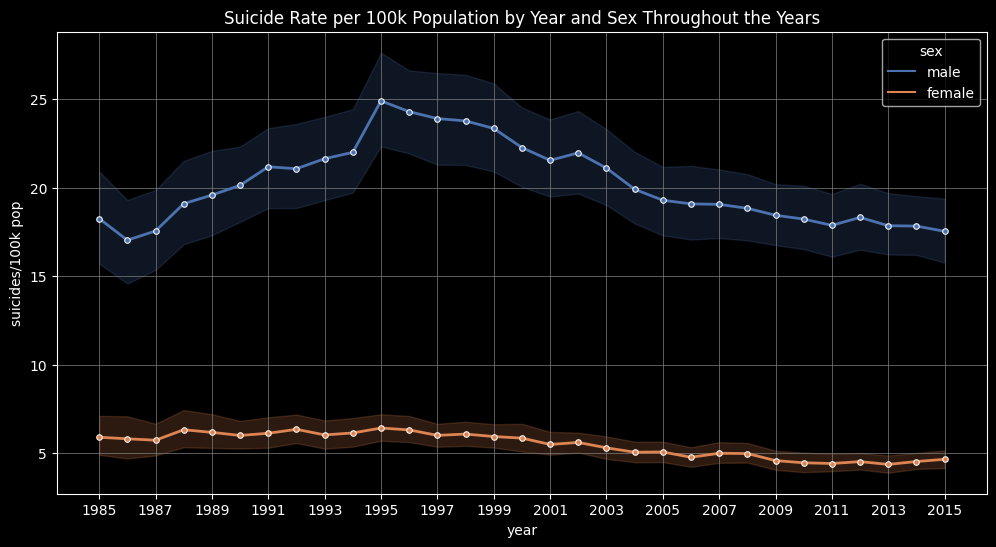

In [30]:
sns.lineplot(data = data, x = "year", y = "suicides/100k pop", hue = "sex", palette = "deep", marker = ".", linewidth = 2, markersize = 8)
plt.title("Suicide Rate per 100k Population by Year and Sex Throughout the Years")
plt.xticks(range(1985, 2016, 2))
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

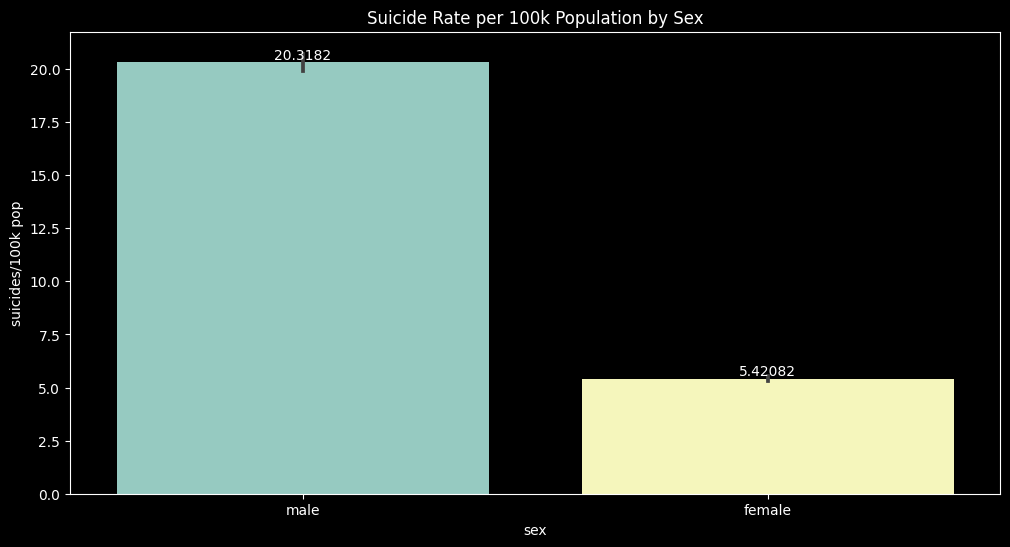

In [31]:
ax = sns.barplot(data = data, x = "sex", y = "suicides/100k pop")
ax.bar_label(ax.containers[0])
plt.title("Suicide Rate per 100k Population by Sex")
plt.show()

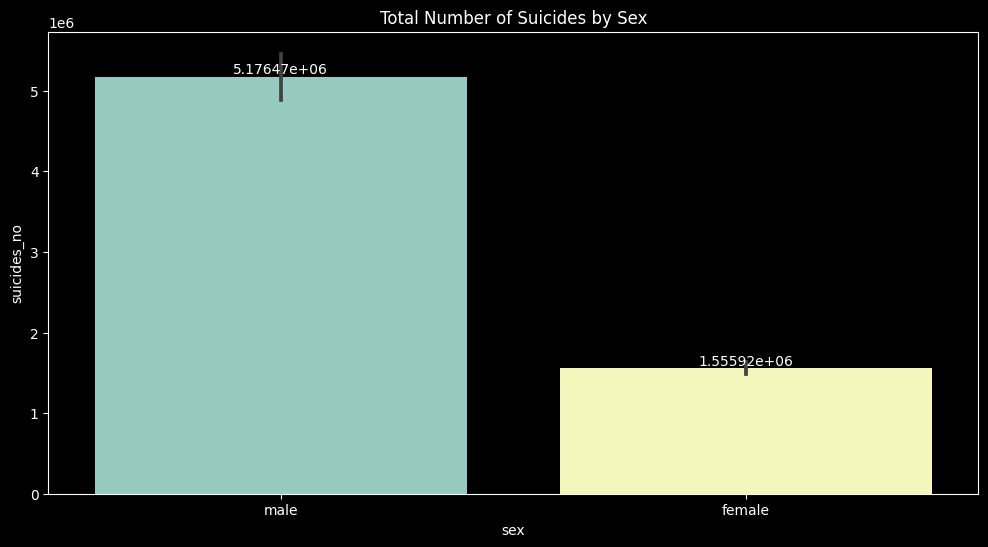

In [32]:
ax = sns.barplot(data = data, x = "sex", y = "suicides_no", estimator = "sum")
ax.bar_label(ax.containers[0])
plt.title("Total Number of Suicides by Sex")
plt.show()

#### Suicide Rate per 100k Population by age group
- It's quite interesting as how the suicide rates increase as the age group increases

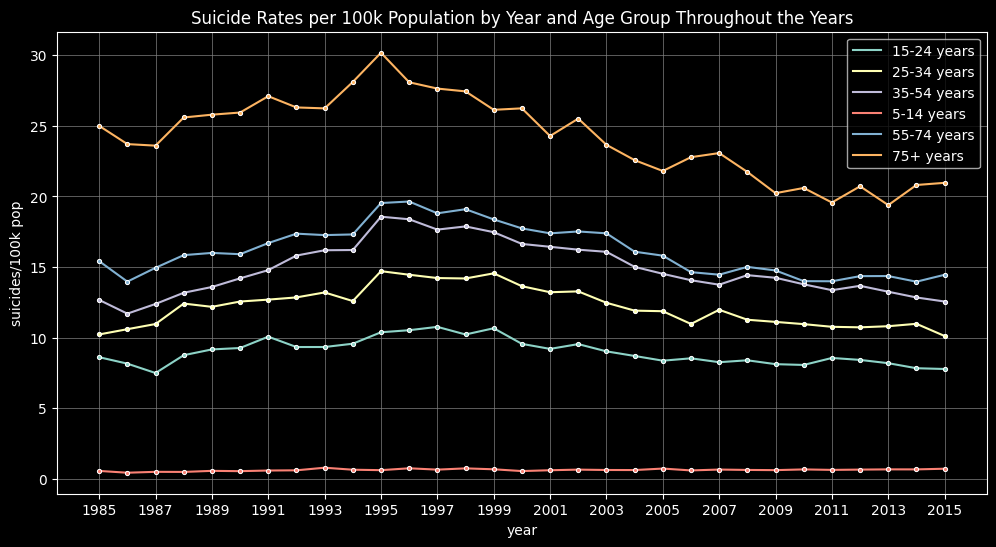

In [33]:
grouped = data.groupby(["year", "age"])["suicides/100k pop"].mean().reset_index()

sns.lineplot(data = grouped, x = "year", y = "suicides/100k pop", hue = "age", marker = ".")
plt.title("Suicide Rates per 100k Population by Year and Age Group Throughout the Years")
plt.xticks(range(1985, 2016, 2))
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.legend()
plt.show()

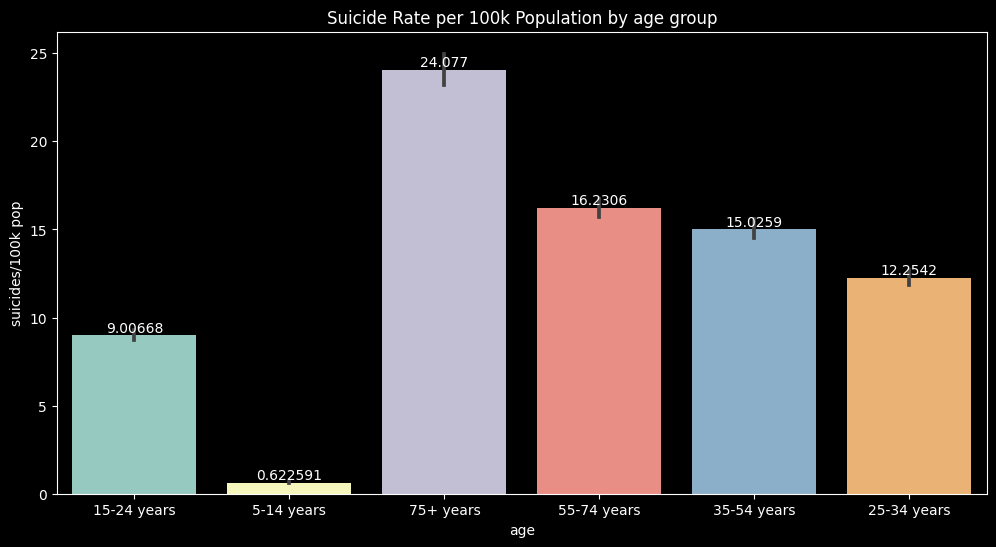

In [34]:
ax = sns.barplot(data = data, x = "age", y = "suicides/100k pop")
plt.bar_label(ax.containers[0])
plt.title("Suicide Rate per 100k Population by age group")
plt.show()

#### Suicide Rate per 100k Population by Generation
- The G.I. Generation's last recorded suicides were in 2000, while Millennials and Generation Z had their first recorded suicides in 1991 and 2007, respectively.
- Maybe, this is because of the period these generations were born. For example, the G.I. Generation and Silent Generation lived through World War II and experienced the Great Depression resulting in a higher suicide rates

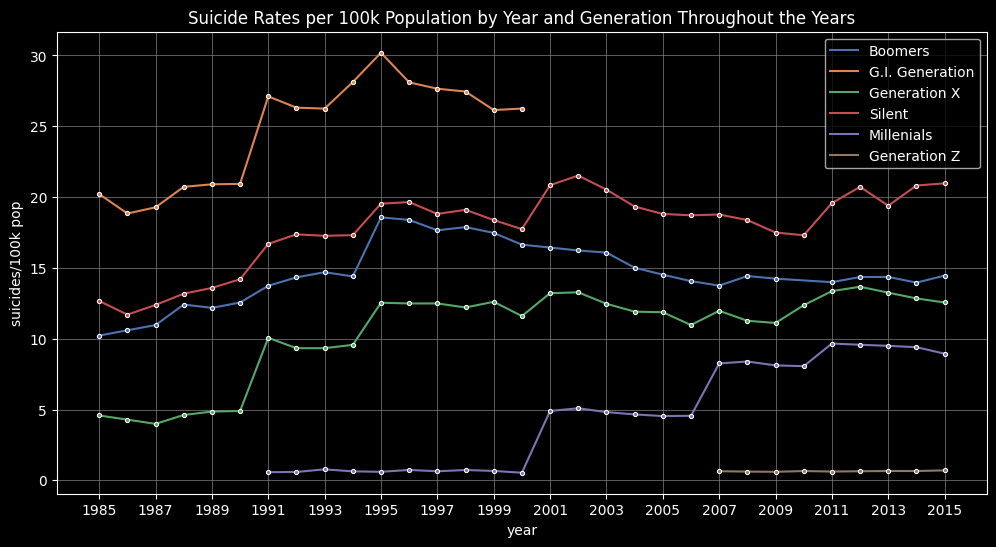

In [35]:
grouped = data.groupby(["year", "generation"])["suicides/100k pop"].mean().reset_index()
sns.lineplot(data = grouped, x = "year", y = "suicides/100k pop", hue = "generation", palette = "deep", marker = ".")
plt.title("Suicide Rates per 100k Population by Year and Generation Throughout the Years")
plt.xticks(range(1985, 2016, 2))
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.legend()
plt.show()

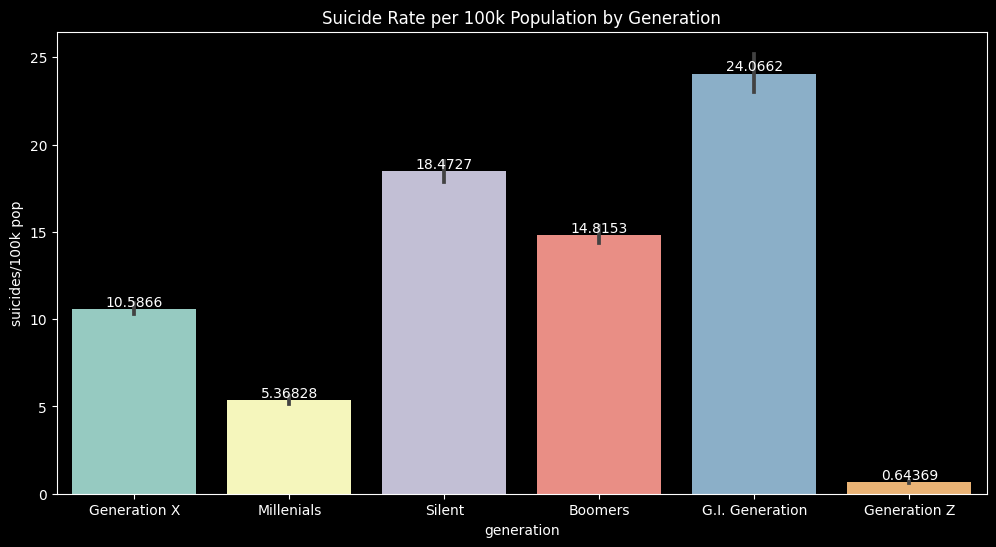

In [36]:
ax = sns.barplot(data = data, x = "generation", y = "suicides/100k pop")
plt.bar_label(ax.containers[0])
plt.title("Suicide Rate per 100k Population by Generation")
plt.show()

#### Suicide Rates by Continent
- There seems to be a fluctations and variations of suicide rates in every continent over time except for Europe and North America which shows a downward trend
- Europe has the highest suicide rate among the continents
- There's also a higher suicide rate among men population in every continent

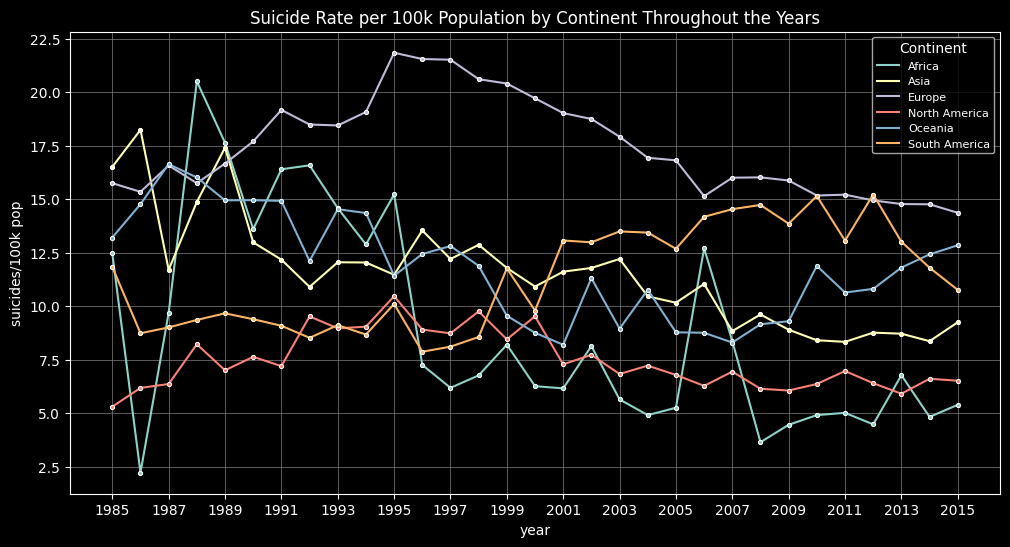

In [37]:
grouped = data.groupby(["year", "Continent"])["suicides/100k pop"].mean().reset_index()
sns.lineplot(data = grouped, x = "year", y = "suicides/100k pop", hue = "Continent", marker = ".")
plt.xticks(range(1985, 2016, 2))
plt.title("Suicide Rate per 100k Population by Continent Throughout the Years")
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.legend(title = "Continent", fontsize = 8)
plt.show()

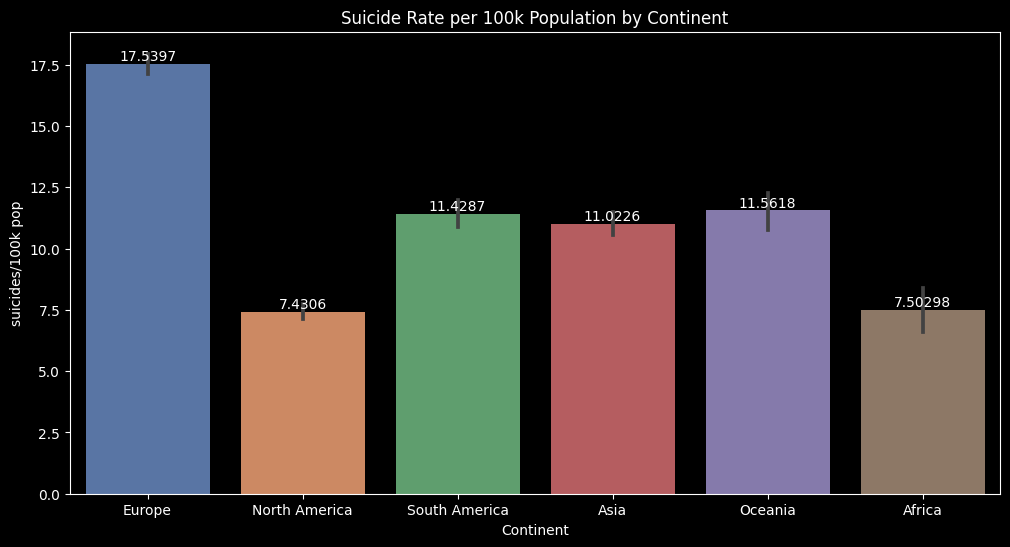

In [38]:
ax = sns.barplot(data = data, x = "Continent", y = "suicides/100k pop", palette = "deep")
plt.bar_label(ax.containers[0])
plt.title("Suicide Rate per 100k Population by Continent")
plt.show()

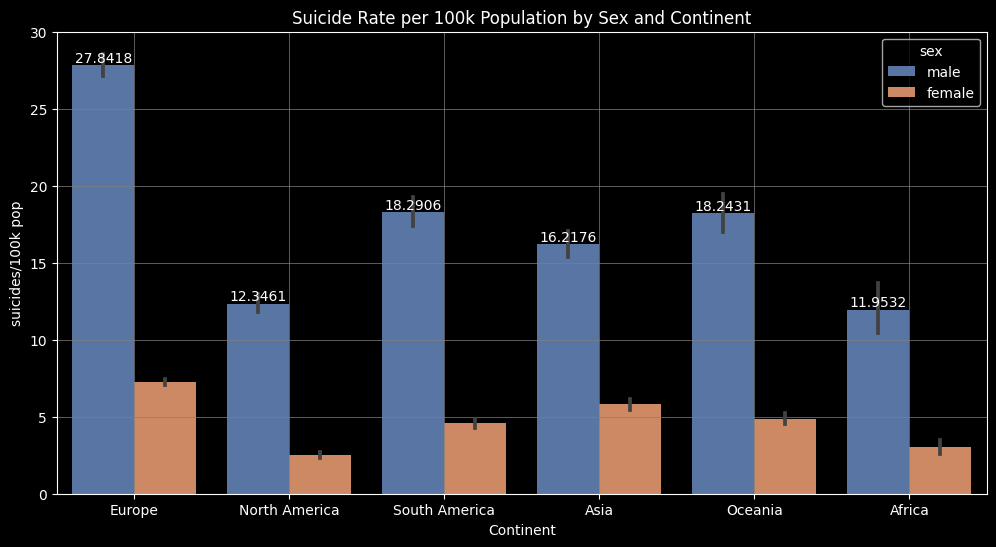

In [39]:
ax = sns.barplot(data = data, x = "Continent", y = "suicides/100k pop", hue = "sex", palette = "deep")
plt.bar_label(ax.containers[0])
plt.title("Suicide Rate per 100k Population by Sex and Continent")
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

#### Suicide Rate throughout the years in each country

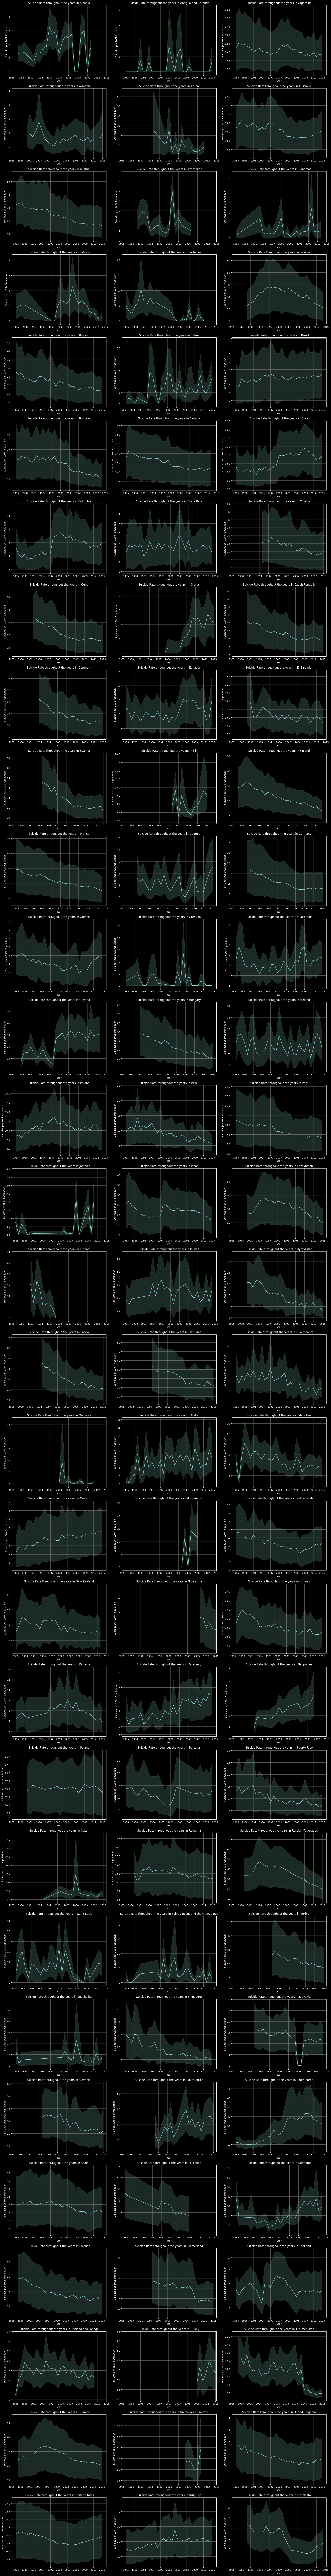

In [40]:
unique_countries = data['country'].unique()

# Calculate the number of rows needed for subplots
num_rows = (len(unique_countries) + 2) // 3

# Set up the figure and axes for subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5*num_rows))

# Iterate through unique countries and plot data in each subplot
for i, country in enumerate(unique_countries):
    country_data = data.loc[data['country'] == country, ["year", "suicides/100k pop"]]
    row = i // 3
    col = i % 3
    sns.lineplot(data=country_data, x="year", y="suicides/100k pop", ax=axes[row, col])
    axes[row, col].set_xticks(range(1985, 2016, 3))
    axes[row, col].set_title(f"Suicide Rate throughout the years in {country}")
    axes[row, col].set_xlabel("Year")
    axes[row, col].set_ylabel("Suicides per 100k Population")
    axes[row, col].grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')


plt.tight_layout()
plt.show()

### Average Suicide Rate per 100k Population in each country using a geographic plot

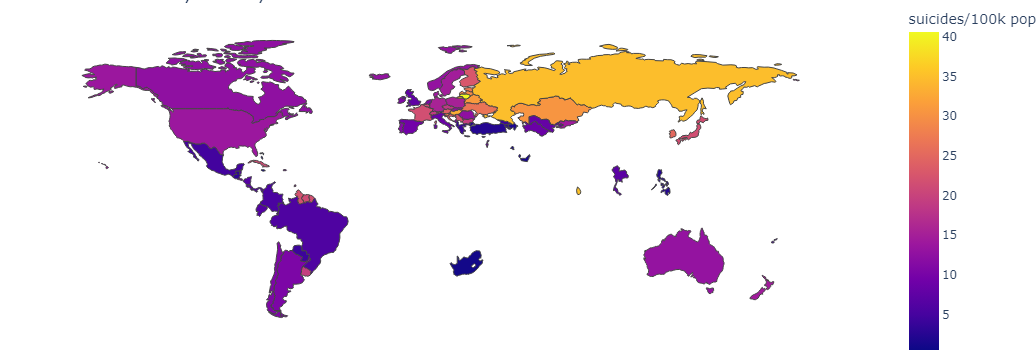

In [61]:
grouped = data.groupby("country")["suicides/100k pop"].mean().reset_index()

fig = px.choropleth(
    grouped,
    locations="country",  # DataFrame column with country names
    locationmode="country names",  # specify that the locations are country names
    color="suicides/100k pop",  # DataFrame column to color by
    hover_name="country",  # DataFrame column to display on hover
    title="Suicide Rates by Country",
    color_continuous_scale=px.colors.sequential.Plasma,  # color scale
    scope = "world"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0))

# Show the interactive plot
fig.show()

#### Suicide Rates per 100k Population by Age Group and Sex Over the Years

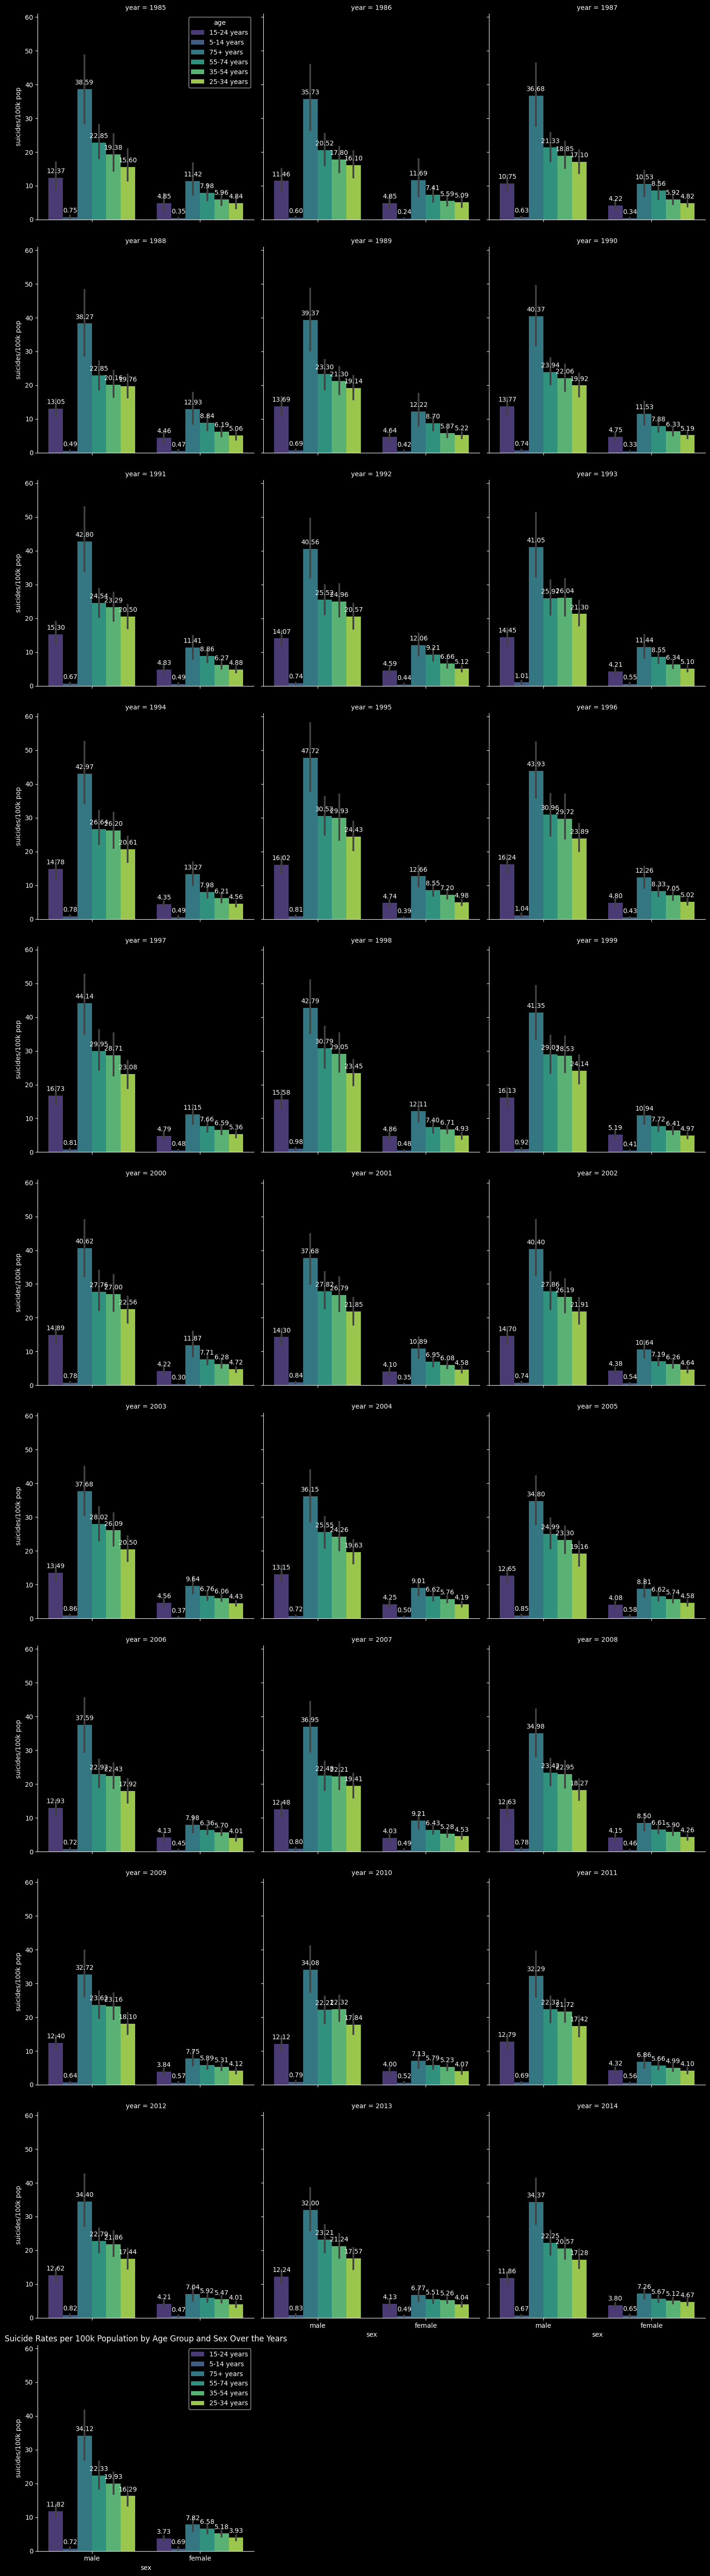

In [41]:
catplot = sns.catplot(data=data, x = 'sex', y = 'suicides/100k pop', hue='age', col='year', kind='bar', col_wrap=3, palette = "viridis", legend_out=False)

# Annotations
for ax in catplot.axes.flat:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', color='white', xytext=(0, 5), textcoords='offset points')

plt.title("Suicide Rates per 100k Population by Age Group and Sex Over the Years")
plt.legend()
plt.tight_layout()
plt.show()